*Autor: Gabriel Mendes*   
[<img alt="Colaboratory logo" width="10%" src="https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white">](https://www.linkedin.com/in/gabriel-mendes-3b4a16149/)

# Previsão de Falhas em Equipamentos utilizando Machine Learning

Neste notebook, utilizei diferentes modelos de machine learning para realizar previsões de falhas em equipamentos, utilizando um dataset contendo diversas informações a respeito do funcionamento dos equipamentos, além das colunas alvo que indicam se o equipamento falhou ou não e o tipo de falha. 

As colunas do dataset são as seguintes:
* UID: identificador das linhas que varia de 1 a 10000;
* productID: consiste em uma letra L, M ou H para baixo (50% de todos os produtos), médio (30%) e alto (20%) respectivamente como variantes de qualidade do produto e um número de série específico da variante;
* air temperature [K]: temperatura do ar em volta do equipamento 
* process temperature [K]: temperatura do processo dentro equipamento;
* rotational speed [rpm]:  torque em que o equipamento operava;
* torque [Nm]: rotação em que o equipamento operava;
* tool wear [min]: desgaste do ferramenta baseada na qualidade do equipamento (L, M ou H)
* target: variável alvo, em que 1 indica que houve a falha e 0 não houve;
* failure Type: indica o tipo de falha do equipamento.


In [2]:
import pandas as pd

df = pd.read_csv("predictive_maintenance.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## Análise Exploratória dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Percebe-se que não há valores nulos no dataset.

In [4]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [5]:
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

É possível perceber o desbalanceamento dos dados, tendo em vista que na coluna da variável alvo (Target), existem 339 ocorrências de falhas (1) para 9661 não ocorrências (0). Assim será necessário balancear o dataset antes de utilizar os modelos. 

In [6]:
# Verificando os tipos de falhas da coluna Failure Type
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [7]:
# Retiramos as variáveis que não utilizaremos do dataset
df = df.drop(["UDI",'Product ID'],axis = 1)

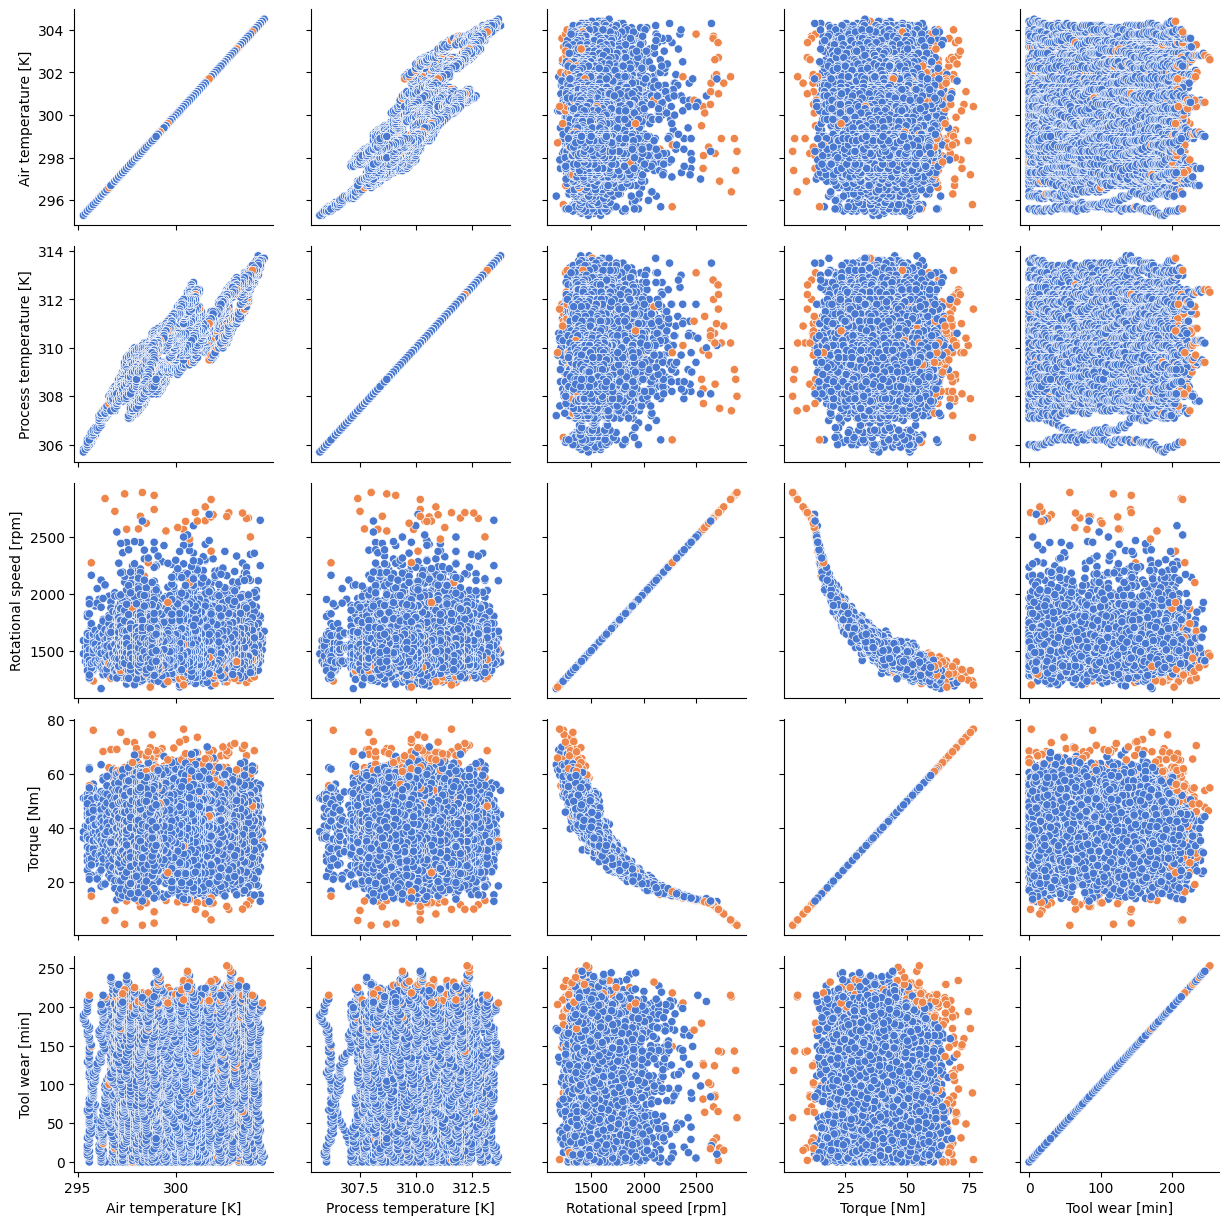

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.PairGrid(df, hue='Target', palette='muted')
g.map(sns.scatterplot)
plt.show()

O comando sns.pairplot(df, hue='Target') cria um conjunto de gráficos de dispersão para cada combinação possível de pares de variáveis numéricas dos dados, onde cada ponto é colorido de acordo com o valor da variável alvo. A opção hue é usada para especificar a variável de destino, enquanto a opção palette é usada para especificar o esquema de cores a ser usado. 

Com esta visualização é possível observar que as falhas (pontos em amarelo nos gráfico) ocorrem para valores extremos das variáveis. Por exemplo no gráfico Air Temperature x Torque, observa-se uma maior distribuição dos pontos amarelos para valores de torque abaixo de 25 e acima de 75 Nm, independente da faixa de temperatura. 

Também é possível observar quais variaveis possuem correlação entre si pela distribuição dos valores nos gráficos. Assim, observa-se que Torque e Rotational Speed são correlacionadas, assim como Process Temperature e Air Temperature. Outra forma de visualizar esta correlação é utilizando o heatmap da seaborn, como mostrado abaixo:

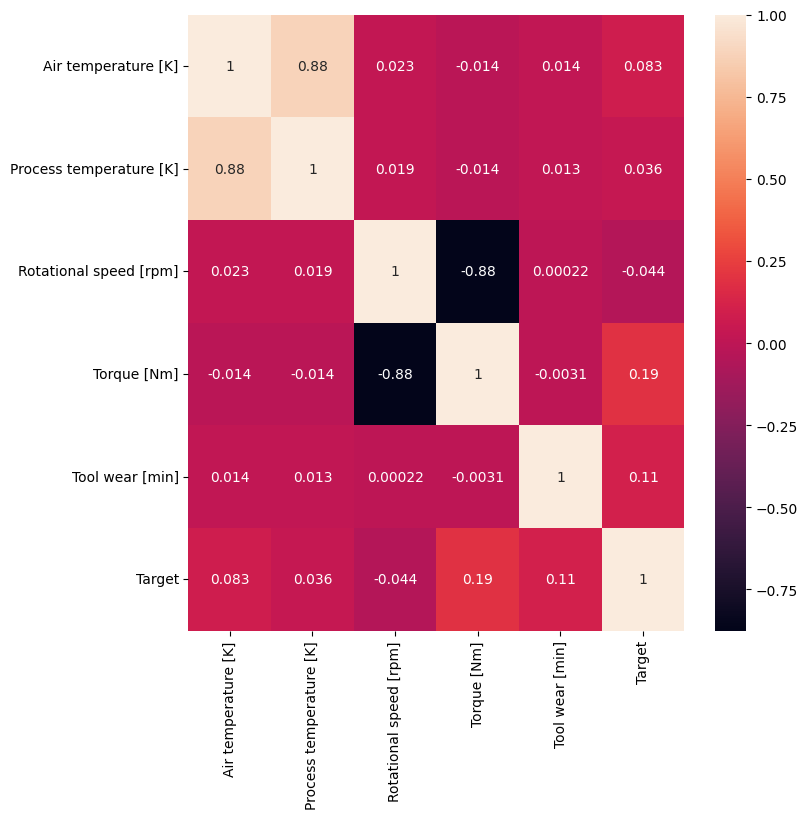

In [9]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()

O heatmap exibe uma cor mais escura para valores mais altos da relação entre as variáveis e uma cor mais clara para valores mais baixos.Os valores indicados representam o coeficiente de correlação de Pearson. Este coeficiente é uma medida estatística que mede a força e a direção da relação linear entre duas variáveis. Ele varia de -1 a 1, onde -1 indica uma correlação negativa perfeita (quando uma variável aumenta, a outra diminui), 0 indica ausência de correlação (as duas variáveis não estão relacionadas) e 1 indica uma correlação positiva perfeita (quando uma variável aumenta, a outra também aumenta).

Os coeficientes com valor igual a 1 no heatmap representam uma correlação da variável com ela mesma, e aqueles com valores próximos de 1 ou -1 representam variáveis que tem forte correlação, seja ela positiva ou negativa. Assim também observa-se a correlação entre Torque e Rotational Speed e Process Temperature e Air Temperature. 

## Avaliando modelos de classificação

### Matrizes de confusão
Uma matriz de confusão é uma tabela que mostra os erros e acertos de modelos de classificação. Em um problema de classificação binário, ela indica 4 valores diferentes acerca do modelo, sendo eles: 
* Verdadeiros negativos: Valores que o modelo classificou como negativos corretamente;
* Falsos negativos: Valores que o modelo classificou erroneamente como negativos; 
* Verdadeiros positivos: Valores que o modelo classificou corretamente como positivos;
* Falsos positivos: Valores que o modelo classificou erroneamente como positivos;

A imagem abaixo ilustra uma matriz de confusão

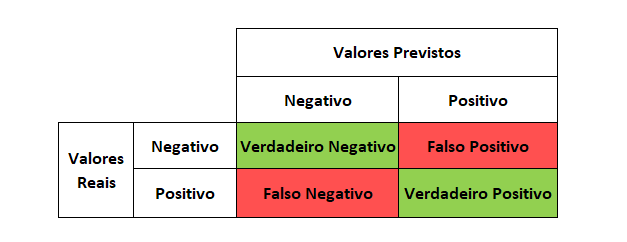

In [49]:
# Exemplo de uma matriz de confusão binária
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0], labels = [0,1]  )
# O parâmetro labels é utilizado para especificar os rótulos das classes para a matriz de confusão

array([[0, 2],
       [1, 1]], dtype=int64)

No exemplo a acima a matriz comparou dois vetores contendo 0 e 1, indicando:
* 0 Verdadeiros negativos
* 2 Falsos positivos
* 1 Falso negativo
* 1 Verdaderio Positivo

### Métricas de Avaliação de Modelos de Classificação

A partir dos valores da matriz de confusão, são obtidas algumas métrica de avaliação do desempenho de modelos de classificação, sendo elas:
* Acurácia: É a proporção de predições corretas do modelo em relação ao total de previsões. É uma métrica simples e intuitiva, mas pode não ser a mais adequada quando as classes estão desbalanceadasÉ a proporção entre todas as classificações. 

* Precisão: É a proporção de verdadeiros positivos (VP) em relação à soma de VP e falsos positivos (FP). É uma métrica útil quando é importante evitar falsos positivos. A Precisão tenta responder a seguinte questão: Qual proporção dos resultados positivos identificados eram de fato positivos ?

* Recall ou Sensibilidade: É a proporção de VP em relação à soma de VP e falsos negativos (FN). É uma métrica útil quando é importante evitar falsos negativos. O Recall tenta responder a seguinte questão: Qual proporção dos resultados corretos tanto para verdadeiro positivo como falso negativo foram identificados corretamente ?

* F1-score: É a média harmônica entre precisão e recall. É uma métrica que leva em consideração tanto a precisão quanto o recall e é útil quando se deseja um equilíbrio entre essas duas métricas.

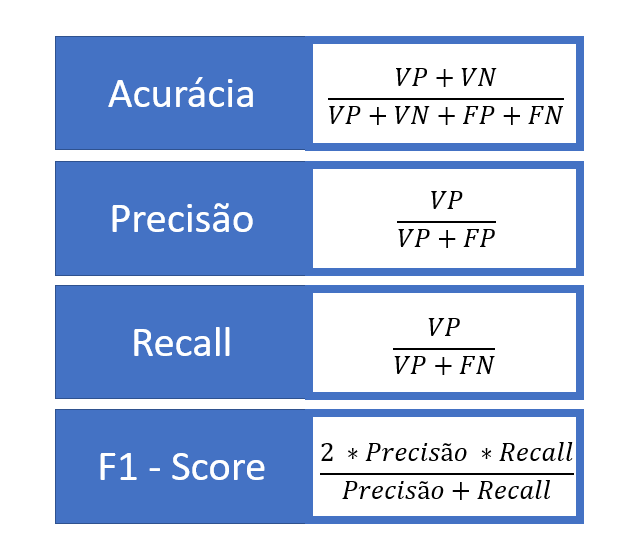

In [71]:
# Exemplo de cálculo das métricas de avaliação
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
real=[0, 1, 0, 1]
previsao=[1, 1, 1, 0]

print("Matriz de confusão: \n",confusion_matrix(real, previsao, labels = [0,1]))

print("Acurácia:", accuracy_score(real,previsao))
print("Precisão: {:.2f}" .format(precision_score(real,previsao)))
print("Recall:", recall_score(real,previsao))
print("F1-Score:", f1_score(real,previsao))



Matriz de confusão: 
 [[0 2]
 [1 1]]
Acurácia: 0.25
Precisão: 0.33
Recall: 0.5
F1-Score: 0.4


## Utilizandos Modelos de Machine Learning para fazer as previsões

In [ ]:
# Primeiramente selecionamos a variável alvo (y) e as features dos modelos (X)
X = df.drop(["Type","Target",'Failure Type'],axis=1)
y = df.Target

# Então separamos o conjunto de dados em dados de teste e treino
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [83]:
# Primeiro utilizarei o modelo Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Treinando o modelo Random Forest Classifier
rf_model = RandomForestClassifier(random_state = 1)

rf_model.fit(X_train,y_train)

# Fazendo as previsões com os dados de teste
y_pred_rf = rf_model.predict(X_test)

# Exibindo a matriz de confusão e as métricas para o modelo Random Forest Classifier
print("Matriz de Confusão")
print(confusion_matrix(y_test,y_pred_rf, labels=[0,1]), "\n")

print("Acurácia: {:.2f}" .format(accuracy_score(y_test,y_pred_rf)))
print("Precisão: {:.2f}" .format(precision_score(y_test,y_pred_rf)))
print("Recall: {:.2f}" .format(recall_score(y_test,y_pred_rf)))
print("F1-Score: {:.2f}" .format(f1_score(y_test,y_pred_rf)))

Matriz de Confusão
[[3171   15]
 [  40   74]] 

Acurácia: 0.98
Precisão: 0.83
Recall: 0.65
F1-Score: 0.73


In [81]:
# Utilizando o modelo de Regressão Logística
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=1)
lr_model.fit(X_train,y_train)
y_pred_lr = lr_model.predict(X_test)

print("Matriz de Confusão")
print(confusion_matrix(y_test,y_pred_lr, labels=[0,1]), "\n")

print("Acurácia: {:.2f}" .format(accuracy_score(y_test,y_pred_lr)))
print("Precisão: {:.2f}" .format(precision_score(y_test,y_pred_lr)))
print("Recall: {:.2f}" .format(recall_score(y_test,y_pred_lr)))
print("F1-Score: {:.2f}" .format(f1_score(y_test,y_pred_lr)))


Matriz de Confusão
[[3180    6]
 [  90   24]] 

Acurácia: 0.97
Precisão: 0.80
Recall: 0.21
F1-Score: 0.33


É possível perceber os dois modelos apresentaram um bom resultado para a Acurácia porém resultados ruins para o Recall. O valor do Recall foi baixo para devido a grande quantidade de falsos negativos que o modelo apresentou. Isto ocorreu devido ao desbalanceamento dos dados, já que dos 10000 registros da variável alvo, apenas 339 representam equiapmentos que apresentaram falhas. Com isto os modelos apresentam dificuldades para aprender a distinguir a classe minoritária, pois a quantidade de exemplos positivos é insuficiente para treina-los adequadamente.

Quando as classes do conjunto de dados estão desbalanceadas, isto é, quando há uma grande diferença na quantidade de observações em cada classe, o modelo de machine learning pode ter dificuldades em aprender com eficácia as características das classes minoritárias e acabar favorecendo a classe majoritária. Isso pode levar a um modelo enviesado e impreciso, com baixo desempenho na previsão de novos dados.

Assim, é necessário fazer o balanceamento dos dados com o objetivo de igualar ou aproximar a quantidade de observações em cada classe para que o modelo possa aprender adequadamente as características de todas as classes e fazer previsões mais precisas. Isto pode ser feito com técnicas como o oversampling (aumento da frequência de amostras da classe minoritária), undersampling (redução da frequência de amostras da classe majoritária). 

### Balaceamento dos Dados

Tendo em vista o desbalanceamento dos dados será necessário fazer um balanceamento do dataset. Isto é necessário para evitar vieses e melhorar a precisão dos resultados dos modelos. Neste trabalho irei utilizar a técnica de undersampling, utilizando a biblioteca imbalanced-learn.

In [82]:
# Instalando a biblioteca necessária
#!pip install -U imbalanced-learn

In [13]:
# Importando o RandomUnderSampler do imblearn
from imblearn.under_sampling import RandomUnderSampler

# Definindo o RandomUnderSampler
rus = RandomUnderSampler(random_state=1)

# Aplicando para X e y
X_res, y_res = rus.fit_resample(X_train, y_train)

# Contando os valores em cada classe
y_res.value_counts()

0    227
1    227
Name: Target, dtype: int64

Com isto temos uma base de dados balanceada, apresentando 227 registros de cada classe (falha ou não falha). Assim podemos treinar novamente os modelos com a base balanceada e avaliá-los.

In [84]:
# Modelo Random Forest Classifier
# Treinando o modelo novamente
rf_model.fit(X_res, y_res)

# Fazendo as previsões com os dados de teste
y_pred_rf = rf_model.predict(X_test)


print("Matriz de Confusão")
print(confusion_matrix(y_test,y_pred_rf, labels=[0,1]), "\n")

print("Acurácia: {:.2f}" .format(accuracy_score(y_test,y_pred_rf)))
print("Precisão: {:.2f}" .format(precision_score(y_test,y_pred_rf)))
print("Recall: {:.2f}" .format(recall_score(y_test,y_pred_rf)))
print("F1-Score: {:.2f}" .format(f1_score(y_test,y_pred_rf)))

Matriz de Confusão
[[2848  338]
 [   3  111]] 

Acurácia: 0.90
Precisão: 0.25
Recall: 0.97
F1-Score: 0.39


In [85]:
# Utilizando o modelo de Regressão Logística

lr_model = LogisticRegression(random_state=1)
lr_model.fit(X_res,y_res)
y_pred_lr = lr_model.predict(X_test)

print("Matriz de Confusão")
print(confusion_matrix(y_test,y_pred_lr, labels=[0,1]), "\n")

print("Acurácia: {:.2f}" .format(accuracy_score(y_test,y_pred_lr)))
print("Precisão: {:.2f}" .format(precision_score(y_test,y_pred_lr)))
print("Recall: {:.2f}" .format(recall_score(y_test,y_pred_lr)))
print("F1-Score: {:.2f}" .format(f1_score(y_test,y_pred_lr)))


Matriz de Confusão
[[2581  605]
 [  13  101]] 

Acurácia: 0.81
Precisão: 0.14
Recall: 0.89
F1-Score: 0.25
